In [5]:
from utils import *
from network import *

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
weights = load_pretrained_weights()

In [7]:
voxceleb_dataset = VoxCelebDataset(PAIRS_FILE)
train_dataloader = DataLoader(voxceleb_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=4)
n_batches = int(len(voxceleb_dataset) / BATCH_SIZE)

print("training unique users", len(voxceleb_dataset.training_users))
print("training samples", len(voxceleb_dataset))
print("batches", int(len(voxceleb_dataset) / BATCH_SIZE))

training unique users 80
training samples 12800
batches 400


In [8]:
checkpoints = os.listdir(get_rel_path('checkpoints/'))
print("\n".join(checkpoints))

checkpoint_20181211-050019_0.007421350106596947.pth.tar
checkpoint_20181211-051049_0.0071602994576096535.pth.tar
checkpoint_20181211-030043_0.014894404448568821.pth.tar
checkpoint_20181208-211625_0.014224099926650524.pth.tar
checkpoint_20181208-081759_0.14750675857067108.pth.tar
checkpoint_20181211-023809_0.036916766315698624.pth.tar
checkpoint_20181208-212603_0.011183960363268852.pth.tar
checkpoint_20181208-084522_0.00958214234560728.pth.tar
checkpoint_20181208-090431_0.007160770706832409.pth.tar
checkpoint_20181208-082002_0.025060191750526428.pth.tar
checkpoint_20181208-082817_0.014348131604492664.pth.tar
checkpoint_20181211-042846_0.008861738257110119.pth.tar
checkpoint_20181208-205935_0.040470466017723083.pth.tar
checkpoint_20181208-213806_0.00952972937375307.pth.tar
checkpoint_20181211-034639_0.016438601538538933.pth.tar
checkpoint_20181208-083429_0.0120355524122715.pth.tar
checkpoint_20181208-213052_0.01061977632343769.pth.tar
checkpoint_20181208-090227_0.007458028383553028.pth.t

In [11]:
test_model ,_, _ = load_saved_model('checkpoint_20181208-090431_0.007160770706832409.pth.tar', test=True)

### for each user ID get mean embedding 

In [ ]:
class VoxCelebTestDataset(Dataset):
    
    def __init__(self, pairs_fname,  test_users, n_users=5, clips_per_user=5):
        pairs_file = pd.read_csv(get_rel_path(pairs_fname))        
        user_subset = pairs_file[pairs_file.user1.isin(test_users)]
        self.test_users =  user_subset.user1.unique()
        self.spec = user_subset[user_subset.user1.isin(self.test_users)]      
        self.spec = self.spec.drop_duplicates(subset = ['path1'])[['user1', 'path1']].values  

    def __len__(self):
        return len(self.spec)

    def __getitem__(self, idx):
        spec1_path = get_rel_path(self.spec[idx][1])
        user_id = self.spec[idx][0]
        spec1 = np.load(spec1_path)  
        sample = {'spec': spec1, 'user_id': user_id}

        return sample

In [13]:
test_batch_size = 1
training_users = voxceleb_dataset.training_users
total_users = voxceleb_dataset.all_user_ids
test_users = [i for i in total_users if i not in training_users]

In [15]:
voxceleb_train_dataset = VoxCelebTestDataset(PAIRS_FILE, training_users, clips_per_user=NUM_NEW_CLIPS, n_users=20)

train_dataloader = DataLoader(voxceleb_train_dataset, 
                              batch_size=test_batch_size, 
                              shuffle=False, 
                              num_workers=1)

print(len(voxceleb_train_dataset), "training samples")
print(len(voxceleb_train_dataset.test_users))

800 training samples
80


In [15]:
def get_user_model(dataset):
    user_dict = OrderedDict()

    for i, data in enumerate(dataset):
        spec, user_id = data['spec'], data['user_id']
        spec = torch.tensor(spec)
        spec = spec.view(test_batch_size, 1, spec.shape[0], spec.shape[1])
        spec = spec.to(device)
        out = test_model.forward_single(spec)
        out = out.view(out.shape[0], out.shape[1])

        if user_dict.get(user_id, None) is not None:
              user_dict[user_id].append(out.detach().cpu().numpy())
    
        else:
              user_dict[user_id] = [out.detach().cpu().numpy()]

    print("total :", i+1)
    mean_dict = {}
    for user_id, emb_list  in user_dict.items():
        emb_list = np.array(emb_list)
        mean_emb = np.mean(emb_list, axis = 0)
        mean_dict[user_id] = mean_emb

    return user_dict, mean_dict

###  T-sne

In [16]:
def get_tsne_data(dataset):
    data_list, user_list, mean_list = [], [], []
    counts, user = 0, 0
    user_dict, mean_dict = get_user_model(dataset)
    
    for user_id, li in user_dict.items():
        user += 1
        for arr in li:
            data_list.append(arr)
            user_list.append(user)
            counts += 1
        mean_list.append(mean_dict[user_id])

    mean_data = np.vstack(mean_list)
    data = np.vstack(data_list)
    print(data.shape)
    print(counts)
    
    return data, mean_data, user_list

In [ ]:
def plot_tsne(data, user_list):
    tsne = TSNE(n_components=2, perplexity=25, init='pca', random_state=2444, method='exact')
    tsne_embedding = tsne.fit_transform(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(x=tsne_embedding[:,0], y=tsne_embedding[:, 1], c=user_list, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.title('Learned Embeddings for Training Users')
    fname = "training_users_embeddings_" + time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(fname)
    plt.show()
    return tsne_embedding

In [17]:
train_user_data, train_mean_data, train_user_list = get_tsne_data(voxceleb_train_dataset)

total : 800
(800, 1024)
800


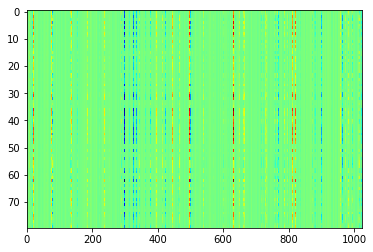

In [18]:
plt.imshow(train_mean_data, aspect='auto', cmap='jet')

### Visualizing Training Users Embeddings

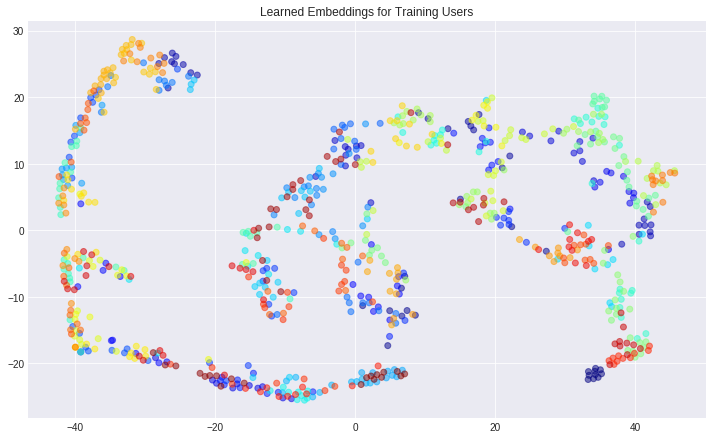

In [21]:
train_users_tsne_embeddings = plot_tsne(train_user_data, train_user_list)

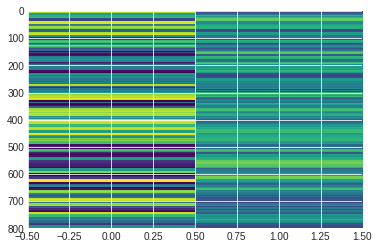

In [22]:
plt.imshow(train_users_tsne_embeddings, aspect='auto', cmap='viridis')

### test phase

In [24]:
voxceleb_test_dataset = VoxCelebTestDataset(PAIRS_FILE, test_users, clips_per_user=5, n_users=10)

test_dataloader = DataLoader(voxceleb_test_dataset, 
                             batch_size=test_batch_size, 
                             shuffle=False, 
                             num_workers=1)

print(len(voxceleb_test_dataset), "test samples")
print(voxceleb_test_dataset.test_users)

200 test samples
['id10095' 'id10096' 'id10093' 'id10092' 'id10091' 'id10097' 'id10100'
 'id10098' 'id10099' 'id10094' 'id10082' 'id10089' 'id10083' 'id10086'
 'id10084' 'id10081' 'id10087' 'id10088' 'id10085' 'id10090']


In [25]:
# def get_accuracy(test_dataset, mean_data):

#     test_user_embeddings, _ = get_user_model(voxceleb_test_dataset)
#     correct, incorrect = 0, 0
    
#     for i,j in enumerate(test_user_embeddings):
#         user_emb_i = np.vstack(test_user_embeddings[j])
#         users_cosine_similarity = cosine_similarity(user_emb_i, mean_data)
#         pred = np.argmax(users_cosine_similarity, axis=1)
#         correct_i = (pred==i).sum()
#         correct += correct_i
#         incorrect += (user_emb_i.shape[0] - correct_i)
    
#     acc = correct / (correct + incorrect)    
    
#     return test_user_embeddings, acc

In [26]:
test_user_embeddings = get_user_model(voxceleb_test_dataset)

total : 200


total : 200
(200, 1024)
200


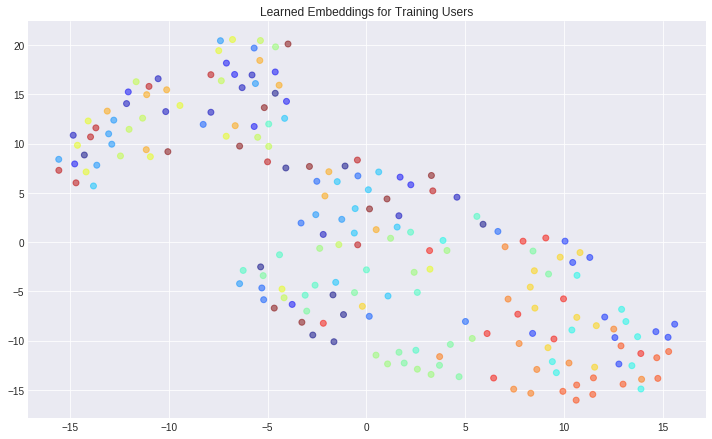

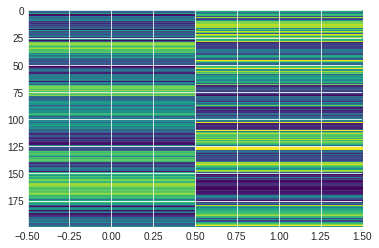

In [28]:
test_user_data, test_mean_data, test_user_list = get_tsne_data(voxceleb_test_dataset)
test_users_tsne_embeddings = plot_tsne(test_user_data, test_user_list)
plt.imshow(test_users_tsne_embeddings, aspect='auto', cmap='viridis')